In [1]:
import os
import gc
import warnings 

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

In [2]:
!pip install xgboost


In [11]:
import IPython


def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [12]:
def on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ

In [13]:
if on_kaggle():
    os.system("pip install --quiet mlflow_extend")

In [14]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [15]:
def read_data():
    INPUT_DIR = "/kaggle/input" if on_kaggle() else "input"
    INPUT_DIR = f"{INPUT_DIR}/m5-forecasting-accuracy"

    print("Reading files...")

    calendar = pd.read_csv("calendar.csv").pipe(reduce_mem_usage)
    prices = pd.read_csv("sell_prices.csv").pipe(reduce_mem_usage)

    #sales = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv",).pipe(
    #    reduce_mem_usage
    #)
    sales = pd.read_csv("sales_train_evaluation.csv",).pipe(
        reduce_mem_usage
    )
    submission = pd.read_csv("sample_submission.csv").pipe(
        reduce_mem_usage
    )

    print("sales shape:", sales.shape)
    print("prices shape:", prices.shape)
    print("calendar shape:", calendar.shape)
    print("submission shape:", submission.shape)

    # calendar shape: (1969, 14)
    # sell_prices shape: (6841121, 4)
    # sales_train_val shape: (30490, 1919)
    # submission shape: (60980, 29)

    return sales, prices, calendar, submission

In [16]:
sales, prices, calendar, submission = read_data()

NUM_ITEMS = sales.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28

Reading files...
sales shape: (30490, 1947)
prices shape: (6841121, 4)
calendar shape: (1969, 14)
submission shape: (60980, 29)


In [17]:
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df


calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales = encode_categorical(
    sales, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

prices = encode_categorical(prices, ["item_id", "store_id"]).pipe(reduce_mem_usage)

In [18]:
def extract_num(ser):
    return ser.str.extract(r"(\d+)").astype(np.int16)


def reshape_sales(sales, submission, d_thresh=0, verbose=True):
    # melt sales data, get it ready for training
    # change column names.

    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    #vals_columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals_columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]
    # separate test dataframes.
    #vals = sales[vals_columns]#submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    # get product table.
    
    
    product = sales[id_columns]
    sales = sales.melt(id_vars=id_columns, var_name="d", value_name="demand",)
    sales = reduce_mem_usage(sales)


    #vals.columns  = vals_columns#["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals.columns = evals_columns#["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    # merge with product table
    # may be edit
    #vals["id"] = vals["id"].str.replace("_validation", "_evaluation")
    #vals = vals.merge(product, how="left", on="id")
    evals = evals.merge(product, how="left", on="id")
    #vals["id"] = vals["id"].str.replace("_evaluation","_validation")

    if verbose:
        #print("validation")
        #display(vals)

        print("evaluation")
        display(evals)

    #vals = vals.melt(id_vars=id_columns, var_name="d", value_name="demand")
    evals = evals.melt(id_vars=id_columns, var_name="d", value_name="demand")

    sales["part"] = "train"
    #sales["part"][~(sales["d"]<1914)] = "validation"
    evals["part"] = "evaluation"

    data = pd.concat([sales, evals], axis=0)

    del sales, evals

    data["d"] = extract_num(data["d"])
    data = data[data["d"] >= d_thresh]

    # delete evaluation for now.
    # data = data[data["part"] != "evaluation"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data


def merge_calendar(data, calendar):
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)
    return data.merge(calendar, how="left", on="d")


def merge_prices(data, prices):
    return data.merge(prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

In [19]:
data = reshape_sales(sales, submission, d_thresh=1941 - int(365 * 2  + 7))
del sales
gc.collect()

calendar["d"] = extract_num(calendar["d"])
data = merge_calendar(data, calendar)
del calendar
gc.collect()

data = merge_prices(data, prices)
del prices
gc.collect()

data = reduce_mem_usage(data)

evaluation


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0


data


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part
36679470,HOBBIES_1_001_CA_1_evaluation,1437,3,1,0,0,1204,0,train
36679471,HOBBIES_1_002_CA_1_evaluation,1438,3,1,0,0,1204,0,train
36679472,HOBBIES_1_003_CA_1_evaluation,1439,3,1,0,0,1204,0,train
36679473,HOBBIES_1_004_CA_1_evaluation,1440,3,1,0,0,1204,4,train
36679474,HOBBIES_1_005_CA_1_evaluation,1441,3,1,0,0,1204,1,train


## feature engineering
Our task was to predict sales for 28 days, so I make diff and roll features based on 28 days.  
I also created more additional features, but allmost of them was not worked...

In [20]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,1437,3,1,0,0,1204,0,train,2014-05-16,11415,NaN,NaN,NaN,NaN,0,0,0,8.26
1,HOBBIES_1_002_CA_1_evaluation,1438,3,1,0,0,1204,0,train,2014-05-16,11415,NaN,NaN,NaN,NaN,0,0,0,3.97
2,HOBBIES_1_003_CA_1_evaluation,1439,3,1,0,0,1204,0,train,2014-05-16,11415,NaN,NaN,NaN,NaN,0,0,0,2.97
3,HOBBIES_1_004_CA_1_evaluation,1440,3,1,0,0,1204,4,train,2014-05-16,11415,NaN,NaN,NaN,NaN,0,0,0,4.64
4,HOBBIES_1_005_CA_1_evaluation,1441,3,1,0,0,1204,1,train,2014-05-16,11415,NaN,NaN,NaN,NaN,0,0,0,3.08


In [21]:
import math, decimal
dec = decimal.Decimal
from datetime import datetime
import datetime as dtime
def get_moon_phase(d):  # 0=new, 4=full; 4 days/phase
    d_1 = datetime.strptime(d, '%Y-%m-%d')
    diff = dtime.datetime.fromordinal(d_1.toordinal()) - datetime(2001, 1, 1)
    days = dec(diff.days) + (dec(diff.seconds) / dec(86400))
    lunations = dec("0.20439731") + (days * dec("0.03386319269"))
    phase_index = math.floor((lunations % dec(1) * dec(8)) + dec('0.5'))
    return int(phase_index) 

# calendar['moon'] = calendar.date.apply(get_moon_phase)
# print(diff, days, phase_index)
data['moon_phase']= data.date.apply(get_moon_phase)



In [12]:
def add_demand_features(df):
    # DAYS_PRED = 28,then
    for diff in [0, 28]:
        shift = DAYS_PRED + diff
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(shift)
        )
    
        
    print("shift done")
    gc.collect()
    ### I edited diff parameters. 
    ### we predict 28 days ahead, so I created diff and roll features 
    ### based on 28 days.
    diff = 28
    for window in [28, 56, 84]:
        df[f"shift_t{diff}_rolling_std_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).std()
        )
        df[f"shift_t{diff}_rolling_mean_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).mean()
        )
        df[f"rolling_min_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).min()
        )
        df[f"rolling_max_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).max()
        )
        df[f"rolling_sum_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(diff).rolling(window).sum()
        )
    print("window done")
    df["rolling_skew_t28"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(28).skew()
    )
    df["rolling_kurt_t28"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(28).kurt()
    )
    df
    return df


def add_price_features(df):
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        df["rolling_price_max_t365"]
    )

    df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(7).std()
    )
    df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(30).std()
    )
    return df.drop(["rolling_price_max_t365", "shift_price_t1"], axis=1)


def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "year",
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    df['month_day']  = df['month'] * 100 + df['day']
    return df


def add_original_features(df):
    df['shift_t28_log']   = np.log(df['shift_t28'] + 1)
    df['shift_t28_sqrt']  = np.sqrt(df['shift_t28'])
    df['shift_t56_log']   = np.log(df['shift_t56'] + 1)
    df['shift_t56_sqrt']  = np.sqrt(df['shift_t56'])

    df['shift_t28_diff_t7'] = df.groupby('id')['shift_t28'].diff(7)
    df['shift_t56_diff_t7'] = df.groupby('id')['shift_t56'].diff(7)
    
    return df
    

In [13]:
def add_demand_features_shift_new(df):
    shift_days =[42, 49, 60, 63]
    for shift in shift_days:
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(shift)
        )
    return df
    print("shift_new done")

In [14]:
data = add_demand_features_shift_new(data).pipe(reduce_mem_usage)

In [ ]:
data.sum()

In [97]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data:  7.8 GiB
                    submission:  6.6 MiB
                           _77: 31.6 KiB
                           _71:  8.1 KiB
                           _35:  3.7 KiB
                          _i73:  3.3 KiB
                          _i16:  2.3 KiB
                             _:  1.8 KiB
                           ___:  1.8 KiB
                           _82:  1.8 KiB


In [15]:
data = add_demand_features(data).pipe(reduce_mem_usage)
print('add_demand_features done')
data = add_price_features(data).pipe(reduce_mem_usage)
print('add_price_features done')
data = add_original_features(data).pipe(reduce_mem_usage)
print('add_original_features done')
dt_col = "date"
data = add_time_features(data, dt_col).pipe(reduce_mem_usage)
data = data.sort_values("date")

print("start date:", data[dt_col].min())
print("end date:", data[dt_col].max())
print("data shape:", data.shape)

shift done
window done
add_demand_features done
add_price_features done
add_original_features done
start date: 2014-05-16 00:00:00
end date: 2016-06-19 00:00:00
data shape: (23355340, 61)


In [66]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [40]:
def split_data(data):

    #Product details upto day 1913 is used as training dataset
    X_train = data[data['d']<=1913]
    y_train = X_train['demand']
    X_train.drop('demand',axis = 1,inplace = True)
    
    # Product details from day 1914 to 1941 is used as validation dataset
    X_val = data[(data['d']>=1914) & (data['d']<=1941)]
    y_val = X_val['demand']
    X_val.drop(['demand'],axis = 1,inplace = True)
    
    # Product details starting from day 1942 is used as testing dataset
    X_test = data[(data['d']>=1942)]
    X_test.drop(['demand'],axis = 1,inplace = True)
    
    #print("Train dataset",X_train.shape,y_train.shape)
    #print("Validation dataset",X_val.shape,y_val.shape)
    #print("Test dataset",X_test.shape)
    return(X_train,y_train,X_val,y_val,X_test)

In [56]:
data_filt = data[data['d']>1850]

In [58]:
for i in data_filt.columns:
    if data_filt[i].dtype=='object':
        data_filt[i]=data_filt[i].astype('category')
        data_filt[i] = data_filt[i].cat.codes


In [57]:
data_filt = data_filt.fillna(0)

In [87]:
data_filt.to_csv('data_filt_final.csv')

In [22]:
data=pd.read_csv('data_filt_final.csv')
#data.drop('weights',inplace=True,axis=1)
data.head()

,Unnamed: 0,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,moon_phase,shift_t42,shift_t49,shift_t60,shift_t63,shift_t28,shift_t56,shift_t28_rolling_std_t28,shift_t28_rolling_mean_t28,rolling_min_t28,rolling_max_t28,rolling_sum_t28,shift_t28_rolling_std_t56,shift_t28_rolling_mean_t56,rolling_min_t56,rolling_max_t56,rolling_sum_t56,shift_t28_rolling_std_t84,shift_t28_rolling_mean_t84,rolling_min_t84,rolling_max_t84,rolling_sum_t84,rolling_skew_t28,rolling_kurt_t28,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,shift_t28_log,shift_t28_sqrt,shift_t56_log,shift_t56_sqrt,shift_t28_diff_t7,shift_t56_diff_t7,year,quarter,month,week,day,dayofweek,is_weekend,month_day
0,19747357,4216,421,1,0,6,1,1851,0,1,11604,0.0,0.0,0.0,0.0,0,0,0,7.98,4,0.0,1.0,0.0,0.0,0.0,0.0,0.416270,0.107143,0.0,2.0,3.0,0.345190,0.089286,0.0,2.0,5.0,0.302030,0.071429,0.0,2.0,6.0,4.126069,17.401083,0.0,0.000000,8.603189e-09,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,2016,1,2,8,22,0,0,-34
1,19747355,4196,419,1,0,6,1,1851,1,1,11604,0.0,0.0,0.0,0.0,0,0,0,2.50,4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.443935,0.196429,0.0,2.0,11.0,0.492631,0.214286,0.0,2.0,18.0,0.000000,0.000000,0.0,0.131944,2.090814e-08,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,2016,1,2,8,22,0,0,-34
2,19747356,4206,420,1,0,6,1,1851,0,1,11604,0.0,0.0,0.0,0.0,0,0,0,9.98,4,1.0,0.0,0.0,1.0,0.0,0.0,0.741798,0.571429,0.0,3.0,16.0,0.872189,0.553571,0.0,3.0,31.0,0.766855,0.452381,0.0,3.0,38.0,1.495646,2.888336,0.0,0.000000,1.265594e-08,1.371161e-08,0.000000,0.000000,0.0,0.0,-1.0,-1.0,2016,1,2,8,22,0,0,-34
3,19747358,4226,422,1,0,6,1,1851,1,1,11604,0.0,0.0,0.0,0.0,0,0,0,6.98,4,2.0,0.0,0.0,2.0,3.0,0.0,0.860663,1.000000,0.0,3.0,28.0,1.341520,1.267857,0.0,7.0,71.0,1.504249,1.380952,0.0,7.0,116.0,0.375381,-0.666277,0.0,0.000000,1.899533e-08,0.000000e+00,1.386294,1.732051,0.0,0.0,2.0,-2.0,2016,1,2,8,22,0,0,-34
4,19747364,4286,428,1,0,6,1,1851,0,1,11604,0.0,0.0,0.0,0.0,0,0,0,2.50,4,0.0,0.0,0.0,3.0,0.0,0.0,0.722832,0.321429,0.0,3.0,9.0,0.724345,0.357143,0.0,3.0,20.0,0.682542,0.333333,0.0,3.0,28.0,2.583960,6.888949,0.0,0.000000,0.000000e+00,2.767076e-09,0.000000,0.000000,0.0,0.0,0.0,-3.0,2016,1,2,8,22,0,0,-34


In [47]:
X = data
y = data['demand']
y.head()

0    0
1    1
2    0
3    1
4    0
Name: demand, dtype: int64

In [50]:
X.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

KeyError: "['Unnamed: 0', 'id'] not found in axis"

In [51]:
X.head()

,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,moon_phase,shift_t42,shift_t49,shift_t60,shift_t63,shift_t28,shift_t56,shift_t28_rolling_std_t28,shift_t28_rolling_mean_t28,rolling_min_t28,rolling_max_t28,rolling_sum_t28,shift_t28_rolling_std_t56,shift_t28_rolling_mean_t56,rolling_min_t56,rolling_max_t56,rolling_sum_t56,shift_t28_rolling_std_t84,shift_t28_rolling_mean_t84,rolling_min_t84,rolling_max_t84,rolling_sum_t84,rolling_skew_t28,rolling_kurt_t28,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,shift_t28_log,shift_t28_sqrt,shift_t56_log,shift_t56_sqrt,shift_t28_diff_t7,shift_t56_diff_t7,year,quarter,month,week,day,dayofweek,is_weekend,month_day
0,421,1,0,6,1,1851,0,1,11604,0.0,0.0,0.0,0.0,0,0,0,7.98,4,0.0,1.0,0.0,0.0,0.0,0.0,0.416270,0.107143,0.0,2.0,3.0,0.345190,0.089286,0.0,2.0,5.0,0.302030,0.071429,0.0,2.0,6.0,4.126069,17.401083,0.0,0.000000,8.603189e-09,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,2016,1,2,8,22,0,0,-34
1,419,1,0,6,1,1851,1,1,11604,0.0,0.0,0.0,0.0,0,0,0,2.50,4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.443935,0.196429,0.0,2.0,11.0,0.492631,0.214286,0.0,2.0,18.0,0.000000,0.000000,0.0,0.131944,2.090814e-08,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,2016,1,2,8,22,0,0,-34
2,420,1,0,6,1,1851,0,1,11604,0.0,0.0,0.0,0.0,0,0,0,9.98,4,1.0,0.0,0.0,1.0,0.0,0.0,0.741798,0.571429,0.0,3.0,16.0,0.872189,0.553571,0.0,3.0,31.0,0.766855,0.452381,0.0,3.0,38.0,1.495646,2.888336,0.0,0.000000,1.265594e-08,1.371161e-08,0.000000,0.000000,0.0,0.0,-1.0,-1.0,2016,1,2,8,22,0,0,-34
3,422,1,0,6,1,1851,1,1,11604,0.0,0.0,0.0,0.0,0,0,0,6.98,4,2.0,0.0,0.0,2.0,3.0,0.0,0.860663,1.000000,0.0,3.0,28.0,1.341520,1.267857,0.0,7.0,71.0,1.504249,1.380952,0.0,7.0,116.0,0.375381,-0.666277,0.0,0.000000,1.899533e-08,0.000000e+00,1.386294,1.732051,0.0,0.0,2.0,-2.0,2016,1,2,8,22,0,0,-34
4,428,1,0,6,1,1851,0,1,11604,0.0,0.0,0.0,0.0,0,0,0,2.50,4,0.0,0.0,0.0,3.0,0.0,0.0,0.722832,0.321429,0.0,3.0,9.0,0.724345,0.357143,0.0,3.0,20.0,0.682542,0.333333,0.0,3.0,28.0,2.583960,6.888949,0.0,0.000000,0.000000e+00,2.767076e-09,0.000000,0.000000,0.0,0.0,0.0,-3.0,2016,1,2,8,22,0,0,-34


In [26]:
xtrain,ytrain,xval,yval,xtest=split_data(data)


## Running Grid Search to find Optimum Parameters

In [29]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import xgboost as xg


## Ridge Regression Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_reg = linear_model.Ridge()
ridge_grid = [{'alpha': [0.001,0.01,0.1,1,10],
 'solver': ['lsqr','auto', 'saga']}]


grid = GridSearchCV(ridge_reg, ridge_grid, verbose = 3, scoring='neg_root_mean_squared_error')
grid.fit(xtrain, ytrain)
grid.best_params_ # this gives us the best hyperparameters



In [37]:
## Running a Nested CV on all the models to find the best among them - 1st dataset
# Set up possible values of parameters to optimize over

p_grid_knn = [{'n_neighbors': range(1,15,1),
 'weights': ['uniform', 'distance']}]

ridge_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000],
 'solver': ['lsqr','auto', 'saga']}]


xg_grid = [{
    'max_depth':[2,4,6],
    'n_estimators':[50,100,200],
    'eta':[0.1,0.3,0.5],
    'subsample': [0.5,1]
}]


In [39]:
# Calling all the Model Functions
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import neighbors

ridge_reg = linear_model.Ridge()
xg = XGBRegressor()
knn = neighbors.KNeighborsRegressor()

inner_cv = KFold(n_splits=4, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=1)

In [ ]:
# Non_nested parameter search and scoring

clf_knn = GridSearchCV(estimator=knn, param_grid=p_grid_knn, cv=inner_cv, scoring='neg_mean_squared_error')
clf_knn.fit(X_norm, y)

clf_rd = GridSearchCV(estimator=ridge_reg, param_grid=ridge_grid, cv=inner_cv, scoring='neg_mean_squared_error')
clf_rd.fit(X_norm, y)

clf_grade = GridSearchCV(estimator=grade, param_grid=gradient_grid, cv=inner_cv, scoring='neg_mean_squared_error')
clf_grade.fit(X_norm, y)

# Nested CV with parameter optimization

nested_score_knn = cross_val_score(clf_knn, X=X_norm, y=y, cv=outer_cv)
print("For KNN we get:", round(nested_score_knn.mean(),4))

nested_score_rd = cross_val_score(clf_rd, X=X_norm, y=y, cv=outer_cv)
print("For Ridge Regression we get:", round(nested_score_rd.mean(),4))

nested_grade = cross_val_score(clf_grade, X=X_norm, y=y, cv=outer_cv)
print("For Gradient Boost Regressor we get:", round(nested_grade.mean(),4))

In [62]:

model = LinearRegression(n_jobs=-1)
model.fit(xtrain,ytrain)
yval_pred  = model.predict(xval)
ytest_pred = model.predict(xtest)

LinearRegression(n_jobs=-1)

In [64]:
rmse = mse(yval,yval_pred)
print(rmse)

4.9884257


In [67]:

model2=linear_model.Ridge()
model2.fit(xtrain,ytrain)
yval_pred  = model2.predict(xval)
ytest_pred = model2.predict(xtest)
rmse = mse(yval,yval_pred)
print(rmse)

4.9803696


In [69]:
import xgboost as xg

xgb = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10,n_jobs=-1)

xgb.fit(xtrain,ytrain)

yval_pred  = xgb.predict(xval)
ytest_pred = xgb.predict(xtest)


[09:14:02] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [70]:

rmse = mse(yval,yval_pred)
print(rmse)

4.864048


In [71]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 3600 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            # step = (duration - total_sec) / (self.n_splits - 1)
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                # train_start = idx * step
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

In [72]:
day_col = "d"
cv_params = {
    "n_splits": 2,
    "train_days": int(365 * 1.5),
    "test_days": 28,#DAYS_PRED,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

In [20]:
data.to_pickle('data_pickle.csv')

In [74]:
data_st1=data[data['store_id']==0]

In [75]:
data_st1.shape

(2335534, 61)

## Feature Selection
I selected feature by feature importance in previous version notebook.  
In evaluation phase(after June 1st), I used `d_1914 - d_1941` sales as a train.

In [76]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features
    "shift_t42",
    "shift_t49",
    "shift_t60",
    "shift_t63",
    "shift_t28",
    "shift_t56",
    "moon_phase",
    # std
    "shift_t28_rolling_std_t28",
    "shift_t28_rolling_std_t56",
    "shift_t28_rolling_std_t84",
    # mean
    "shift_t28_rolling_mean_t28",
    "shift_t28_rolling_mean_t56",
    "shift_t28_rolling_mean_t84",
    # min,
    "rolling_min_t28",
    # max
    "rolling_max_t28",
    "rolling_max_t56",
    # sum
    "rolling_sum_t28",    
    "rolling_sum_t56",        
    "rolling_kurt_t28",    
    "price_change_t365",
    "rolling_price_std_t30",
    # time features
    "year",
    "quarter",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
    "month_day",
    # original features
#     "shift_t28_log",
#     "shift_t28_sqrt",
#     "shift_t56_log",
#     "shift_t56_sqrt",
    "shift_t28_diff_t7",
    'shift_t56_diff_t7'
    #"self_diff_t7",
    #"self_diff_t28"
    
]
# prepare training and test data.
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

is_train = (data_st1["d"] < 1942)# & (data["d"]>=1544)

is_private = (data_st1["d"] >= 1942)
is_public = ~(data_st1["d"] < 1914) & ~(is_private)


# Attach "d" to X_train for cross validation.
X_train = data_st1[is_train][[day_col] + features].reset_index(drop=True)
y_train = data_st1[is_train]["demand"].reset_index(drop=True)
X_test_pub = data_st1[is_public][features].reset_index(drop=True)
X_test_pri = data_st1[is_private][features].reset_index(drop=True)

# keep these two columns to use later.
id_date_pub = data_st1[is_public][["id", "date"]].reset_index(drop=True)
id_date_pri = data_st1[is_private][["id", "date"]].reset_index(drop=True)

del data_st1
gc.collect()

print(X_train['d'][0])
print("X_train shape:", X_train.shape)
print("X_test_pub shape:", X_test_pub.shape)
print("X_test_pri shape:", X_test_pri.shape)
print("id_date_pub shape:", id_date_pub.shape)
print("id_date_pri shape:", id_date_pri.shape)

1204
X_train shape: (2250162, 45)
X_test_pub shape: (85372, 44)
X_test_pri shape: (85372, 44)
id_date_pub shape: (85372, 2)
id_date_pri shape: (85372, 2)


In [ ]:
1204
X_train shape: (22501620, 40)
X_test_pub shape: (853720, 39)
X_test_pri shape: (853720, 39)
id_date_pub shape: (853720, 2)
id_date_pri shape: (853720, 2)
model

In [42]:
x_train_st1 = X_train[X_train['state_id']==0]
y_train_st1 = y_train[y_train['state_id']==0]
X_test_pub_st1 = X_test_pub[X_test_pub['state_id'==0]]
X_test_pri_st1 = X_test_pri[X_test_pri['state_id'==0]]

# keep these two columns to use later.
id_date_pub_st1 = id_date_pub[id_date_pub['state_id']==0]
id_date_pri_st1 = id_date_pri[id_date_pri['state_id']==0]

KeyError: 'state_id'

In [30]:
# X_st1=X_st[X_st['state_id']==0]


(23355340, 61)

In [56]:
X_train_st1 = X_st1[is_train][[day_col] + features].reset_index(drop=True)
y_train_st1 = X_st1[is_train]["demand"].reset_index(drop=True)
X_test_pub_st1 = X_st1[is_public][features].reset_index(drop=True)
X_test_pri_st1 = X_st1[is_private][features].reset_index(drop=True)

# keep these two columns to use later.
# id_date_pub_st1 = X_st1[is_public][["id", "date"]].reset_index(drop=True)
# id_date_pri_st1 = X_st1[is_private][["id", "date"]].reset_index(drop=True)


print(X_train_st1['d'][0])
print("X_train shape:", X_train_st1.shape)
print("X_test_pub shape:", X_test_pub_st1.shape)
print("X_test_pri shape:", X_test_pri_st1.shape)
# print("id_date_pub shape:", id_date_pub_st1.shape)
# print("id_date_pri shape:", id_date_pri_st1.shape)

1204
X_train shape: (9000648, 45)
X_test_pub shape: (341488, 44)
X_test_pri shape: (0, 44)


In [38]:
# X_train.to_pickle('x_train_123.csv')
# y_train.to_pickle('y_train_123.csv')
# X_test_pub.to_pickle('x_test_pub_123.csv')
# X_test_pri.to_pickle('x_test_123.csv')

# id_date_pub.to_pickle('id_date_pub_123.csv')
# id_date_pri.to_pickle('id_date_pri_123.csv')


## model
I used single LightGBM model.  
Our task is predict amount of sales, so I selected `poisson` regression as `objective`.  
I used `rmse` metric for loss function.

I also tried `tweedie` regression, but `poisson` was better than that.  
In hyperparameter tuning, I used [Optuna](https://optuna.org/) on my local PC because it took more than 9 hours to tuning.  

This notebook shows tuned parameters and that's score was the best in my all submission,   
but I selected "NOT tuned model" as a final submission...

In [26]:
# def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
#     models = []

#     if drop_when_train is None:
#         drop_when_train = []

#     for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
#         print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")

#         X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
#         y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        
#         print(f'\n train d min: {X_trn["d"].min()} \n valid d min: {X_val["d"].min()} \n')
        
#         train_set = lgb.Dataset(
#             X_trn.drop(drop_when_train, axis=1),
#             label=y_trn,
#             categorical_feature=["item_id"],
#         )
#         val_set = lgb.Dataset(
#             X_val.drop(drop_when_train, axis=1),
#             label=y_val,
#             categorical_feature=["item_id"],
#         )
#         eval_result = {}
#         model = lgb.train(
#             bst_params,
#             train_set,
#             valid_sets=[train_set, val_set],
#             valid_names=["train", "valid"],
#             evals_result=eval_result,
#             **fit_params,
#         )
#         models.append(model)

#         del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
#         gc.collect()

#     return models, eval_result

In [77]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []
    
    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        
        print(f'\n train d min: {X_trn["d"].min()} \n valid d min: {X_val["d"].min()} \n')
        
        train_set = lgb.Dataset(
            X_trn.drop(drop_when_train, axis=1),
            label=y_trn,
            categorical_feature=["item_id"],
        )
        val_set = lgb.Dataset(
            X_val.drop(drop_when_train, axis=1),
            label=y_val,
            categorical_feature=["item_id"],
        )
        eval_result = {}
        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            evals_result=eval_result,
            **fit_params,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models, eval_result

In [78]:
bst_params =  {'lambda_l1': 0.00021301070633699974,
               'lambda_l2': 9.242591106708853e-07,
               'num_leaves': 31, 
               'feature_fraction': 0.584,
               'bagging_fraction': 1.0, 
               'bagging_freq': 0, 
               'min_child_samples': 20, 
               'boosting_type': 'gbdt',
               'metric': 'rmse',
               'objective': 'poisson',
               'n_jobs': -1,
               'seed': 42,
               'learning_rate': 0.03,
               'min_data_in_leaf': 20}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 100,
    "verbose_eval": 100,
}

models, evals = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=[day_col]
)

del X_train, y_train
gc.collect()


----- Fold: (1 / 2) -----


 train d min: 1339 
 valid d min: 1886 

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7384
[LightGBM] [Info] Number of data points in the train set: 1667803, number of used features: 40
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Start training from score 0.362621
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 2.42813	valid's rmse: 2.25111
[200]	train's rmse: 2.30651	valid's rmse:

0

In [79]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

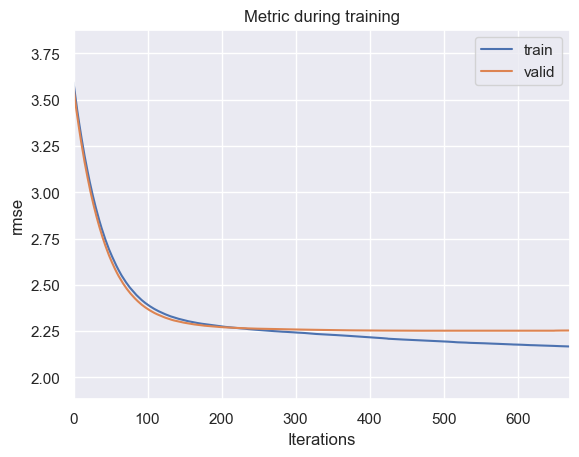

In [80]:
lgb.plot_metric(evals)

In [81]:
imp_type = "gain"
importances = np.zeros(X_test_pub.shape[1])
preds_pub = np.zeros(X_test_pub.shape[0])
preds_pri = np.zeros(X_test_pri.shape[0])

for model in models:
    importances += model.feature_importance(imp_type)

preds_pub = models[0].predict(X_test_pub)
preds_pri = models[0].predict(X_test_pri)
importances = importances / cv.get_n_splits()

In [82]:
def make_submission(test_pub, test_pri, submission):
    preds_pub = test_pub[["id", "date", "demand"]]
    preds_pub['id'] = preds_pub['id'].str.replace("_evaluation", "_validation")
    print(preds_pub['id'].head())
    preds_pri = test_pri[["id", "date", "demand"]]
    # 01-28: validation
    # 29-56: evaluation
    val_dur  = preds_pub["date"]<"2016-05-23"

    preds_val  = preds_pub[val_dur]
    preds_eval = preds_pri#[eval_dur]

    preds_val = preds_val.pivot(index="id", columns="date", values="demand").reset_index()
    preds_eval = preds_eval.pivot(index="id", columns="date", values="demand").reset_index()
    
    print(preds_val.shape)
    print(preds_eval.shape)
    
    
    preds_val.columns = ["id"] + ["F" + str(d+1) for d in range(28)]
    preds_eval.columns = ["id"] + ["F" + str(d+1) for d in range(28)]
    
    
    preds_val = preds_val[preds_val['id'].str.endswith("validation")]
    preds_eval = preds_eval[preds_eval['id'].str.endswith("evaluation")]
    
    
    vals = submission[submission["id"].str.endswith("validation")]
    vals = submission[["id"]].merge(preds_val, how="inner", on="id")
    
    evals = submission[submission["id"].str.endswith("evaluation")]
    evals = submission[["id"]].merge(preds_eval, how="inner", on="id")
    
    final = pd.concat([vals, evals])
    
    
    return final



In [83]:
output = make_submission(id_date_pub.assign(demand=preds_pub), id_date_pri.assign(demand=preds_pri), submission)

0    HOUSEHOLD_2_179_CA_1_validation
1    HOUSEHOLD_2_178_CA_1_validation
2    HOUSEHOLD_2_177_CA_1_validation
3    HOUSEHOLD_2_176_CA_1_validation
4    HOUSEHOLD_2_175_CA_1_validation
Name: id, dtype: object
(3049, 29)
(3049, 29)


In [84]:
output.to_csv("submission_private1cv_store1.csv", index=False)

In [ ]:
[10:59, 12/8/2022] Aravind Carlson: from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=3)
[10:59, 12/8/2022] Aravind Carlson: param_dist = {
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['tweedie', 'poisson', 'regression'],
    'n_estimators': [500,1000],
    'metric': ['rmse'],
    'max_depth': [30, 50, 70],
    'num_leaves': [100, 255, 400],
    'learning_rate': [0.015, 0.02],
    'feature_fraction': [0.5, 0.7],
    'bagging_fraction': [0.5, 0.7],
}
[10:59, 12/8/2022] Aravind Carlson: n_iter_search = 10
reg = lgb.LGBMRegressor()
random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)
[10:59, 12/8/2022] Aravind Carlson: random_search.fit(
    X_train, 
    Y_train,
    eval_metric='rmse',
    eval_set=[(X_train, Y_train), (X_test, Y_test)],
    verbose=1,
)